In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from sentinelhub import SHConfig
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

In [5]:
from sentinelhub import SHConfig
from dotenv import load_dotenv
import os
import numpy as np
from utils import get_map
import datetime
import os
import matplotlib.pyplot as plt
from sentinelhub import CRS, BBox, bbox_to_dimensions
from utils import evalscript_true_color, evalscript_ndvi, evalscript_ndwi
from utils import center_crop
from config import IMAGE_SIZE
from utils import to_grayscale
import cv2
from utils import generated_lsm_mask
from PIL import Image
from torch.utils.data import DataLoader
from dataset import Image_dataset
from generator_model import Generator
from torch import optim
import torch
from config import DEVICE

# Load model
gen = Generator(in_channels=1, inter_images=4, out_channels=1)
checkpoint = torch.load("model/gen_LSM_v1.pth.tar", map_location=torch.device(DEVICE))
gen.load_state_dict(checkpoint['state_dict'])

optimizer = optim.Adam(gen.parameters())
optimizer.load_state_dict(checkpoint['optimizer'])

config_sentinel = SHConfig(sh_client_id=os.environ.get("sh_client_id"), sh_client_secret=os.environ.get("sh_client_secret"))
config_sentinel.sh_client_id

SyntaxError: unmatched ']' (dataset.py, line 67)

In [4]:
import math

def add_km_to_lat_long(lat, lon, d_lat_km, d_lon_km):
    new_lat = lat + (d_lat_km / 111)
    new_lon = lon + (d_lon_km / (111 * math.cos(math.radians(lat))))
    return new_lat, new_lon

In [3]:
import numpy as np
import folium

grid = 3

additional_km = 1.4 * grid # dont change/exceed this

lat1, long1 = 6.763153, 67.878948

a = {"type":"Polygon","coordinates":[
    [
        [lat1, long1],[0, 0],[0, 0],[0, 0],[0, 0]
     ]
    ]
}

min_lon, min_lat = a['coordinates'][0][0][1], a['coordinates'][0][0][0] # Lower-left corner

max_lat, max_lon = add_km_to_lat_long(min_lat, min_lon, additional_km, additional_km)

lon = np.linspace(min_lon, max_lon, grid+1)
lat = np.linspace(min_lat, max_lat, grid+1)

latlons = []
for i in range(len(lat)-1):
    for k in range(len(lon)-1):
        latlons.append((lat[k], lon[i], lat[k+1], lon[i+1]))

m = folium.Map(
    location=[(min_lat + max_lat) / 2, (min_lon + max_lon) / 2],
    zoom_start=13,
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri'
)

cords = []
for k in latlons:
    cord = [(k[0], k[1]), (k[2], k[3])]
    cords.append([k[1], k[0], k[3], k[2]])
    folium.Rectangle(cord, color='red', fill='pink',fill_opcity=0.5).add_to(m)
m

NameError: name 'add_km_to_lat_long' is not defined

In [32]:
actual_grid = []
for row in range(grid):
    g = []
    for col in range(grid):
        g.append(cords[row * grid + col])  # Correct indexing
    actual_grid.append(g)

sub_boxes = np.array(actual_grid)

In [5]:
from tqdm import tqdm
from time import time

def generate_grid_pred(cords_grid, columns=None, rows=None):

    if not columns: columns = len(cords_grid[0])
    if not rows: rows = len(cords_grid)
    
    grid_pred, grid_gray = [], []
    resolution = 0.8
    for row in tqdm(cords_grid[:rows], total=rows): 
        grid_pred_row, grid_gray_row = [], []
        for column in row[:columns]:  
            column = list(column)
            # import pdb; pdb.set_trace()
            print(column)
            maps = get_map(column, start_date="2024-11-06", end_date="2024-12-06",
                evalscript_ndvi=evalscript_ndvi,
                evalscript_true_color=evalscript_true_color,
                evalscript_ndwi=evalscript_ndwi)
            
            new_shape = (IMAGE_SIZE, IMAGE_SIZE)

            gray_image = cv2.resize(to_grayscale(maps[0]), (new_shape[0], new_shape[1]))
            NDVI = cv2.resize(maps[1], (new_shape[0], new_shape[1]))
            Slope = cv2.resize(maps[2], (new_shape[0], new_shape[1]))
            Elevation = cv2.resize(maps[3], (new_shape[0], new_shape[1]))
            NDWI = cv2.resize(maps[4], (new_shape[0], new_shape[1]))

            gray_image_n = cv2.normalize(gray_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
            NDVI_n = cv2.normalize(NDVI, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
            Slope_n = cv2.normalize(Slope, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
            Elevation_n = cv2.normalize(Elevation, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
            NDWI_n = cv2.normalize(NDWI, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

            canvas = np.ones((128, 128*5))
            canvas[:, 0:128] = gray_image_n
            canvas[:, 128:128*2] = NDVI_n
            canvas[:, 128*2:128*3] = Slope_n
            canvas[:, 128*3:128*4] = Elevation_n
            canvas[:, 128*4:128*5] = NDWI_n

            pred = generated_lsm_mask(gen, canvas, already_grayscale=True)
            grid_pred_row.append(pred)
            grid_gray_row.append(gray_image_n)
        grid_pred.append(grid_pred_row)
        grid_gray.append(grid_gray_row)
        
    return grid_pred, grid_gray

    

In [34]:
a = generate_grid_pred(sub_boxes)

  0%|          | 0/3 [00:00<?, ?it/s]

[-109.121194, 44.664106, -109.10346072739424, 44.67671861261261]
[-109.121194, 44.67671861261261, -109.10346072739424, 44.68933122522522]
[-109.121194, 44.68933122522522, -109.10346072739424, 44.70194383783783]


 33%|███▎      | 1/3 [01:20<02:41, 80.65s/it]

[-109.10346072739424, 44.664106, -109.08572745478845, 44.67671861261261]
[-109.10346072739424, 44.67671861261261, -109.08572745478845, 44.68933122522522]
[-109.10346072739424, 44.68933122522522, -109.08572745478845, 44.70194383783783]


 67%|██████▋   | 2/3 [02:26<01:11, 71.90s/it]

[-109.08572745478845, 44.664106, -109.06799418218269, 44.67671861261261]
[-109.08572745478845, 44.67671861261261, -109.06799418218269, 44.68933122522522]
[-109.08572745478845, 44.68933122522522, -109.06799418218269, 44.70194383783783]


100%|██████████| 3/3 [03:20<00:00, 66.98s/it]


In [37]:
from config import IMAGE_RESIZED

rows = len(a[0])
columns = len(a[0][0])
option = 0

grid_canvas = np.zeros((IMAGE_RESIZED*rows, IMAGE_RESIZED*columns))
for row in range(rows):
    for column in range(columns):
        start_row = row * IMAGE_RESIZED
        end_row = (row + 1) * IMAGE_RESIZED
        start_col = column * IMAGE_RESIZED
        end_col = (column + 1) * IMAGE_RESIZED
        # Swap rows and columns and flip rows
        flipped_row = rows - 1 - row
        grid_canvas[start_row:end_row, start_col:end_col] = cv2.resize(a[option][column][flipped_row], (IMAGE_RESIZED, IMAGE_RESIZED))

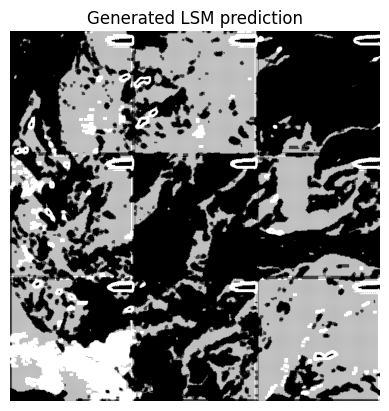

In [42]:
%matplotlib inline

thres_min = 0.2
thres_max = 0.9

blurred_image = cv2.blur(grid_canvas, (7,7))
thresholded_image = (blurred_image > thres_min) & (blurred_image < thres_max)
# mask = (blurred_image ) 

plt.imshow(thresholded_image, cmap="gray")
plt.title("Generated LSM prediction")
plt.axis("off")
plt.show()

In [13]:
def return_grid_canvas(columns, rows, a, option):
    grid_canvas = np.zeros((IMAGE_RESIZED*rows, IMAGE_RESIZED*columns))
    for row in range(rows):
        for column in range(columns):
            start_row = row * IMAGE_RESIZED
            end_row = (row + 1) * IMAGE_RESIZED
            start_col = column * IMAGE_RESIZED
            end_col = (column + 1) * IMAGE_RESIZED
            # Swap rows and columns and flip rows
            flipped_row = rows - 1 - row
            grid_canvas[start_row:end_row, start_col:end_col] = cv2.resize(a[option][column][flipped_row], (IMAGE_RESIZED, IMAGE_RESIZED))
    return grid_canvas

In [14]:
from PIL import Image
import io
from config import IMAGE_RESIZED
import folium

def main(lat, lon, grid):
        ## Fetch colored Sat image
        print("Fetching colored Sat image")

        additional_km = 1.4 * grid # dont change/exceed this

        a = {"type":"Polygon","coordinates":[
        [
                [lat, lon],[0, 0],[0, 0],[0, 0],[0, 0]
        ]
        ]
        }

        min_lon, min_lat = a['coordinates'][0][0][1], a['coordinates'][0][0][0] # Lower-left corner

        max_lat, max_lon = add_km_to_lat_long(min_lat, min_lon, additional_km, additional_km)

        lon = np.linspace(min_lon, max_lon, grid+1)
        lat = np.linspace(min_lat, max_lat, grid+1)

        latlons = []
        for i in range(len(lat)-1):
                for k in range(len(lon)-1):
                        latlons.append((lat[k], lon[i], lat[k+1], lon[i+1]))

        m = folium.Map(
                location=[(min_lat + max_lat) / 2, (min_lon + max_lon) / 2],
                zoom_start=13,
                tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                attr='Esri'
        )
        # Add rectangle gird
        print("Adding rectangle gird")
        cords = []
        for k in latlons:
                cord = [(k[0], k[1]), (k[2], k[3])]
                cords.append([k[1], k[0], k[3], k[2]])
                folium.Rectangle(cord, color='red', fill='pink',fill_opcity=0.5).add_to(m)
                
        actual_grid = []
        for row in range(grid):
                g = []
                for col in range(grid):
                        g.append(cords[row * grid + col])  # Correct indexing
                actual_grid.append(g)
        sub_boxes = np.array(actual_grid)

        

        ## Generated Prediction
        print("Generated Prediction")
        a = generate_grid_pred(sub_boxes)
        
        rows = len(a[0])
        columns = len(a[0][0])

        thres_min = 0.2
        thres_max = 0.9

        option = 0
        
        grid_canvas = return_grid_canvas(columns, rows, a, option=0)

        # Blur and threshold
        print("Blur and threshold")
        blurred_image = cv2.blur(grid_canvas, (7,7))
        thresholded_image = (blurred_image > thres_min) & (blurred_image < thres_max)

        print("Map to png")
        img_data = m._to_png(5)
        img = Image.open(io.BytesIO(img_data))

        cords = sub_boxes[0][0]
        resolution = 0.8
        bbox = BBox(bbox=list(cords), crs=CRS.WGS84)
        size = bbox_to_dimensions(bbox, resolution=resolution)

        ## Get image of different features
        print("Getting image of different features")
        maps = get_map(list(cords), start_date="2021-01-12", end_date="2023-07-13", 
                evalscript_ndvi=evalscript_ndvi, 
                evalscript_true_color=evalscript_true_color, 
                evalscript_ndwi=evalscript_ndwi)

        new_shape = (IMAGE_SIZE, IMAGE_SIZE)

        # Normalize and resize
        print("Normalizing and resize")
        gray_image = cv2.resize(to_grayscale(maps[0]), (new_shape[0], new_shape[1]))
        NDVI = cv2.resize(maps[1], (new_shape[0], new_shape[1]))
        Slope = cv2.resize(maps[2], (new_shape[0], new_shape[1]))
        Elevation = cv2.resize(maps[3], (new_shape[0], new_shape[1]))
        NDWI = cv2.resize(maps[4], (new_shape[0], new_shape[1]))

        gray_image_n = cv2.normalize(gray_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        NDVI_n = cv2.normalize(NDVI, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        Slope_n = cv2.normalize(Slope, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        Elevation_n = cv2.normalize(Elevation, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        NDWI_n = cv2.normalize(NDWI, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

        # Generate canvas
        canvas = np.ones((128, 128*5))
        canvas[:, 0:128] = gray_image_n
        canvas[:, 128:128*2] = NDVI_n
        canvas[:, 128*2:128*3] = Slope_n
        canvas[:, 128*3:128*4] = Elevation_n
        canvas[:, 128*4:128*5] = NDWI_n

        return img, cv2.cvtColor(np.uint8(canvas), cv2.COLOR_GRAY2RGB), (thresholded_image * 1.)


In [ ]:
44.664106 , -109.121194

In [15]:
import gradio as gr

iface = gr.Interface(
    fn=main,
    inputs=[gr.Number(label="Latitude"), gr.Number(label="Longitude"), gr.Number(label="Grid")],
    outputs=[
        gr.Image(type="pil", label="Map Image"),
        gr.Image(type="pil", label="Canvas"),
        gr.Image(type="pil", label="Prediction")
    ],
    # live=True
)
iface.launch()

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


Fetching colored Sat image
Adding rectangle gird
Generated Prediction


  0%|          | 0/1 [00:00<?, ?it/s]

[80.094545, 12.892824, 80.10748381107044, 12.905436612612611]


100%|██████████| 1/1 [00:16<00:00, 16.92s/it]


Blur and threshold
Map to png
Getting image of different features
Normalizing and resize
Fetching colored Sat image
Adding rectangle gird
Generated Prediction


  0%|          | 0/2 [00:00<?, ?it/s]

[80.086706, 12.884758, 80.09964439427225, 12.897370612612612]
[80.086706, 12.897370612612612, 80.09964439427225, 12.909983225225226]


 50%|█████     | 1/2 [00:34<00:34, 34.73s/it]

[80.09964439427225, 12.884758, 80.11258278854449, 12.897370612612612]
[80.09964439427225, 12.897370612612612, 80.11258278854449, 12.909983225225226]


100%|██████████| 2/2 [01:06<00:00, 33.29s/it]


Blur and threshold
Map to png
Getting image of different features
Normalizing and resize
Fetching colored Sat image
Adding rectangle gird
Generated Prediction


  0%|          | 0/3 [00:00<?, ?it/s]

[74.605624, 35.181401, 74.62105544404827, 35.194013612612615]
[74.605624, 35.194013612612615, 74.62105544404827, 35.20662622522522]
[74.605624, 35.20662622522522, 74.62105544404827, 35.219238837837835]


 33%|███▎      | 1/3 [01:04<02:08, 64.27s/it]

[74.62105544404827, 35.181401, 74.63648688809651, 35.194013612612615]
[74.62105544404827, 35.194013612612615, 74.63648688809651, 35.20662622522522]
[74.62105544404827, 35.20662622522522, 74.63648688809651, 35.219238837837835]


 67%|██████▋   | 2/3 [02:11<01:06, 66.04s/it]

[74.63648688809651, 35.181401, 74.65191833214477, 35.194013612612615]
[74.63648688809651, 35.194013612612615, 74.65191833214477, 35.20662622522522]
[74.63648688809651, 35.20662622522522, 74.65191833214477, 35.219238837837835]


100%|██████████| 3/3 [03:13<00:00, 64.56s/it]


Blur and threshold
Map to png
Getting image of different features
Normalizing and resize
Fetching colored Sat image


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gradio/queueing.py", line 536, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gradio/blocks.py", line 1935, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gradio/blocks.py", line 1520, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/L

Fetching colored Sat image
Adding rectangle gird
Generated Prediction


  0%|          | 0/3 [00:00<?, ?it/s]

[86.868376, 27.9656, 86.88265611117218, 27.978212612612612]
[86.868376, 27.978212612612612, 86.88265611117218, 27.990825225225223]
[86.868376, 27.990825225225223, 86.88265611117218, 28.003437837837836]


 33%|███▎      | 1/3 [00:56<01:53, 56.88s/it]

[86.88265611117218, 27.9656, 86.89693622234437, 27.978212612612612]
[86.88265611117218, 27.978212612612612, 86.89693622234437, 27.990825225225223]
[86.88265611117218, 27.990825225225223, 86.89693622234437, 28.003437837837836]


 67%|██████▋   | 2/3 [01:51<00:55, 55.75s/it]

[86.89693622234437, 27.9656, 86.91121633351655, 27.978212612612612]
[86.89693622234437, 27.978212612612612, 86.91121633351655, 27.990825225225223]
[86.89693622234437, 27.990825225225223, 86.91121633351655, 28.003437837837836]


100%|██████████| 3/3 [02:40<00:00, 53.62s/it]


Blur and threshold
Map to png
Getting image of different features
Normalizing and resize
Fetching colored Sat image
Adding rectangle gird
Generated Prediction


  0%|          | 0/5 [00:00<?, ?it/s]

[86.760695, 27.860021, 86.77496117790136, 27.872633612612614]
[86.760695, 27.872633612612614, 86.77496117790136, 27.885246225225224]
[86.760695, 27.885246225225224, 86.77496117790136, 27.897858837837838]
[86.760695, 27.897858837837838, 86.77496117790136, 27.910471450450448]
[86.760695, 27.910471450450448, 86.77496117790136, 27.92308406306306]


 20%|██        | 1/5 [01:17<05:08, 77.25s/it]

[86.77496117790136, 27.860021, 86.78922735580272, 27.872633612612614]
[86.77496117790136, 27.872633612612614, 86.78922735580272, 27.885246225225224]
[86.77496117790136, 27.885246225225224, 86.78922735580272, 27.897858837837838]
[86.77496117790136, 27.897858837837838, 86.78922735580272, 27.910471450450448]
[86.77496117790136, 27.910471450450448, 86.78922735580272, 27.92308406306306]


 40%|████      | 2/5 [02:28<03:41, 73.91s/it]

[86.78922735580272, 27.860021, 86.80349353370407, 27.872633612612614]
[86.78922735580272, 27.872633612612614, 86.80349353370407, 27.885246225225224]
[86.78922735580272, 27.885246225225224, 86.80349353370407, 27.897858837837838]
[86.78922735580272, 27.897858837837838, 86.80349353370407, 27.910471450450448]
[86.78922735580272, 27.910471450450448, 86.80349353370407, 27.92308406306306]


 60%|██████    | 3/5 [03:38<02:24, 72.20s/it]

[86.80349353370407, 27.860021, 86.81775971160543, 27.872633612612614]
[86.80349353370407, 27.872633612612614, 86.81775971160543, 27.885246225225224]
[86.80349353370407, 27.885246225225224, 86.81775971160543, 27.897858837837838]
[86.80349353370407, 27.897858837837838, 86.81775971160543, 27.910471450450448]
[86.80349353370407, 27.910471450450448, 86.81775971160543, 27.92308406306306]


 80%|████████  | 4/5 [04:49<01:11, 71.35s/it]

[86.81775971160543, 27.860021, 86.8320258895068, 27.872633612612614]
[86.81775971160543, 27.872633612612614, 86.8320258895068, 27.885246225225224]
[86.81775971160543, 27.885246225225224, 86.8320258895068, 27.897858837837838]
[86.81775971160543, 27.897858837837838, 86.8320258895068, 27.910471450450448]
[86.81775971160543, 27.910471450450448, 86.8320258895068, 27.92308406306306]


100%|██████████| 5/5 [06:00<00:00, 72.18s/it]


Blur and threshold
Map to png
Getting image of different features
Normalizing and resize


In [11]:
cords = sub_boxes[0][0]
resolution = 0.8
bbox = BBox(bbox=list(cords), crs=CRS.WGS84)
size = bbox_to_dimensions(bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 0.8 m resolution: (1716, 1792) pixels


In [12]:
maps = get_map(list(cords), start_date="2021-06-12", end_date="2023-07-13", 
        evalscript_ndvi=evalscript_ndvi, 
        evalscript_true_color=evalscript_true_color, 
        evalscript_ndwi=evalscript_ndwi)

In [39]:
# gray_image, NDVI, Slope, Elevation, NDWI

In [16]:
new_shape = (IMAGE_SIZE, IMAGE_SIZE)

gray_image = cv2.resize(to_grayscale(maps[0]), (new_shape[0], new_shape[1]))
NDVI = cv2.resize(maps[1], (new_shape[0], new_shape[1]))
Slope = cv2.resize(maps[2], (new_shape[0], new_shape[1]))
Elevation = cv2.resize(maps[3], (new_shape[0], new_shape[1]))
NDWI = cv2.resize(maps[4], (new_shape[0], new_shape[1]))

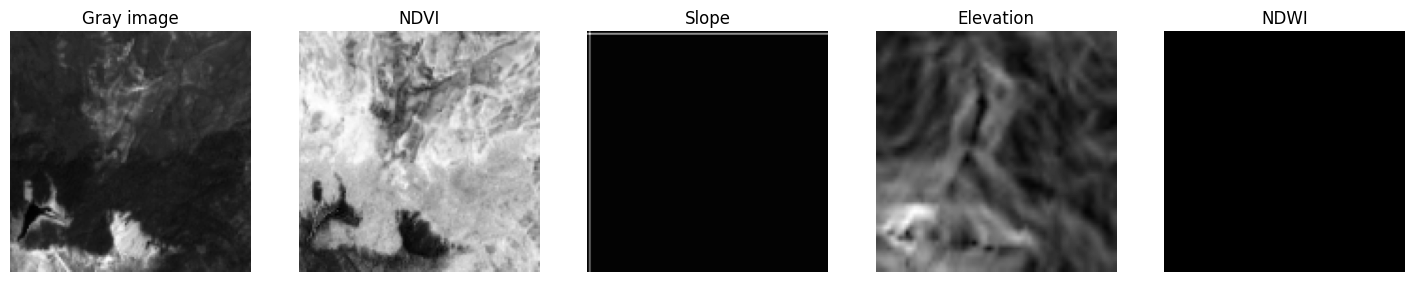

In [17]:
fig,(ax1,ax2, ax3, ax4, ax5)= plt.subplots(1,5,figsize=(18,6))

ax1.set_title("Gray image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("NDWI")

ax1.imshow(gray_image, cmap="gray")
ax2.imshow(NDVI, cmap="gray")
ax3.imshow(Slope, cmap="gray")
ax4.imshow(Elevation, cmap="gray")
ax5.imshow(NDWI, cmap="gray")

ax1.axis("off"); ax2.axis("off"), ax3.axis("off"); ax4.axis("off"), ax5.axis("off")
plt.show()


In [18]:
gray_image_n = cv2.normalize(gray_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
NDVI_n = cv2.normalize(NDVI, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
Slope_n = cv2.normalize(Slope, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
Elevation_n = cv2.normalize(Elevation, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
NDWI_n = cv2.normalize(NDWI, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

(-0.5, 639.5, 127.5, -0.5)

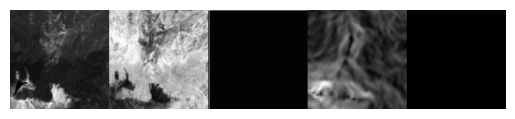

In [20]:
canvas = np.ones((128, 128*5))
canvas[:, 0:128] = gray_image_n
canvas[:, 128:128*2] = NDVI_n
canvas[:, 128*2:128*3] = Slope_n
canvas[:, 128*3:128*4] = Elevation_n
canvas[:, 128*4:128*5] = NDWI_n

plt.imshow(canvas, cmap="gray")
plt.axis("off")

In [ ]:
# pred = generated_lsm_mask(gen, canvas, already_grayscale=True)
# b_i = cv2.blur(pred, (5, 5))
# thresholded = (b_i > 0.1) & (b_i < 0.9)

# plt.imshow(thresholded.astype(float), cmap="gray")
# plt.title("Thresholded and Blurred Prediction")
# plt.axis("off")
# plt.show()